<a href="https://colab.research.google.com/github/liaowanglw/japanese/blob/master/yolo_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.挂载Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive')
! ls -a

'My Drive'   .shortcut-targets-by-id   .Trash


# 2.检查GPU

In [ ]:
!nvidia-smi

Sun Sep 27 01:42:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 3.下载Darknet

In [ ]:
! git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14321 (delta 0), reused 2 (delta 0), pack-reused 14317
Receiving objects: 100% (14321/14321), 12.87 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (9772/9772), done.


In [ ]:
! head darknet/Makefile

GPU=0
CUDNN=0
CUDNN_HALF=0
OPENCV=0
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



# 4.Makefile参数

- GPU=1 调用GPU CUDA

- CUDNN=1 调用cuDNN v5v7加速

- CUDNN_HALF=1调用tensor sores，侦测3倍加速，训练2倍加速

- OPENCV=1 调用opencv 3.x/2.4x 用于摄像机侦测

In [ ]:
! sed -i "s/GPU=0/GPU=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN=0/CUDNN=1/g" /content/darknet/Makefile
! sed -i "s/OPENCV=0/OPENCV=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN_HALF=0/CUDNN_HALF=1/g" /content/darknet/Makefile

In [ ]:
! head darknet/Makefile

GPU=1
CUDNN=1
CUDNN_HALF=1
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



# 5.编译YOLO v4

In [ ]:
! cd darknet; make

# 6.监视训练集

- https://www.kaggle.com/andrewmvd/face-mask-detection/data

- 下载数据集，并上传至Google Drive



In [ ]:
! cp /content/drive/My\ Drive/archive.zip /content/

In [ ]:
! unzip /content/archive.zip > data_zip.log

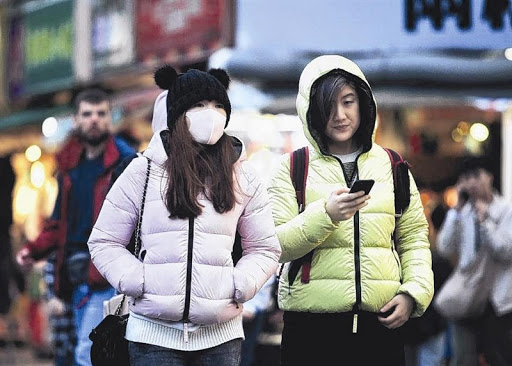

In [ ]:
from PIL import Image
img = Image.open('/content/images/maksssksksss0.png')
img

In [ ]:
! cat '/content/annotations/maksssksksss0.xml'


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [ ]:
! rm -rf /content/yolo
! mkdir /content/yolo

In [ ]:
from bs4 import BeautifulSoup
import os
import shutil

status_dic = {'without_mask': 0, 'mask_weared_incorrect': 1, 'with_mask': 2}
def getYoloFormat(filename, label_path, img_path, yolo_path, newname):
  with open(label_path + filename, 'r') as f:
    soup = BeautifulSoup(f.read(), 'xml')
    imgname = soup.select_one('filename').text
    image_w = int(soup.select_one('width').text)
    image_h = int(soup.select_one('height').text)
    ary = []
    for obj in soup.select('object'):
      xmin = int(obj.select_one('xmin').text)
      xmax = int(obj.select_one('xmax').text)
      ymin = int(obj.select_one('ymin').text)
      ymax = int(obj.select_one('ymax').text)
      objclass = status_dic.get(obj.select_one('name').text)

      x = (xmin + (xmax - xmin) / 2) * 1.0 / image_w 
      y = (ymin + (ymax - ymin) / 2) * 1.0 / image_h
      w = (xmax - xmin) * 1.0 / image_w
      h = (ymax - ymin) * 1.0 / image_h
      ary.append(' '.join([str(objclass), str(x), str(y), str(w), str(h)]))
    if os.path.exists(img_path + imgname):
      shutil.copyfile(img_path + imgname, yolo_path + newname + '.png')
      with open(yolo_path + newname + '.txt', 'w') as f:
        f.write('\n'.join(ary))


In [ ]:
import os
labelpath = '/content/annotations/'
imgpath = '/content/images/'
yolopath = '/content/yolo/'
ary = []
for idx, f in enumerate(os.listdir(labelpath)):
  try:
    getYoloFormat(f, labelpath, imgpath, yolopath, str(idx))
  except Exception as e:
    print(e)

In [ ]:
! cat /content/yolo/2.txt

0 0.9175 0.12734082397003746 0.07 0.12734082397003746
0 0.56 0.20224719101123595 0.07 0.10486891385767791
0 0.0725 0.31647940074906367 0.06 0.09363295880149813
0 0.2925 0.2752808988764045 0.06 0.09363295880149813
0 0.265 0.50187265917603 0.06 0.1348314606741573
2 0.74375 0.2397003745318352 0.0575 0.0898876404494382
2 0.32375 0.46441947565543074 0.0675 0.10486891385767791

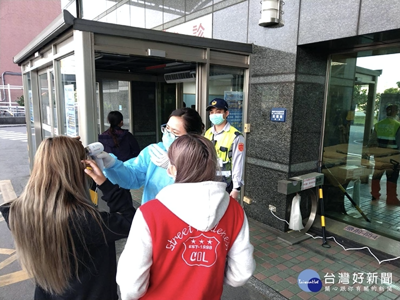

In [ ]:
from PIL import Image
Image.open('/content/yolo/0.png')

# 7.准备训练集和测试集

In [ ]:
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [ ]:
import os
datasets = ['/content/yolo/' + f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
len = int(len(datasets) * 0.8)
len

682

In [ ]:
with open('/content/cfg_mask/train.txt', 'w') as f:
  f.write('\n'.join(datasets[0: 300]))

In [ ]:
with open('/content/cfg_mask/test.txt', 'w') as f:
  f.write('\n'.join(datasets[300: 400]))

# 8.复制参数

In [ ]:
! cp "/content/drive/My Drive/aidataset/cfg_mask/obj.data" cfg_mask/
! cp "/content/drive/My Drive/aidataset/cfg_mask/obj.names" cfg_mask/

In [ ]:
! head /content/cfg_mask/obj.data

classes = 3
train = /content/cfg_mask/train.txt
vaild = /content/cfg_mask/test.txt
names = /content/cfg_mask/obj.names
backup = /content/cfg_mask/weights/

In [ ]:
! head /content/cfg_mask/obj.names

with_mask
mask_weared_incorrect
without_mask

# 9.建立权重资料夹

In [ ]:
! mkdir /content/cfg_mask/weights

# 10.修改 yolov3-tiny.cfg
- YOLO v3侦测的filter大小为(C+5)*B
    - B是每个Feature Map可以侦测的Bounding Box数量
    - 5是Bounding Box的x,y,w,h以及Confidence
    - C是类别数量
- filters=(classes+5)*3 #24
- classes=3



In [ ]:
! cp /content/darknet/cfg/yolov3-tiny.cfg  /content/cfg_mask/

In [ ]:
! sed -n -e 127p -e 135p -e 171p -e 177p /content/cfg_mask/yolov3-tiny.cfg

filters=255
classes=80
filters=255
classes=3


In [ ]:
! sed -i '127s/255/24/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '135s/80/3/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '171s/255/24/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '177s/80/3/' /content/cfg_mask/yolov3-tiny.cfg

In [ ]:
! sed -n -e 127p -e 135p -e 171p -e 177p /content/cfg_mask/yolov3-tiny.cfg

filters=24
classes=3
filters=24
classes=3


# 11.复制权重
- darknet53：利用Imagenet训练出来的53层预训练模型

In [ ]:
! wget https://pjreddie.com/media/files/darknet53.conv.74 /content/drive/My\ Drive/

--2020-09-26 05:39:26--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  4.86MB/s    in 48s     

2020-09-26 05:40:14 (3.25 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]

/content/drive/My Drive/: Scheme missing.
FINISHED --2020-09-26 05:40:14--
Total wall clock time: 49s
Downloaded: 1 files, 155M in 48s (3.25 MB/s)


In [ ]:
! cp /content/drive/My\ Drive/darknet53.conv.74 /content/cfg_mask -r 

# 12.训练模型

In [ ]:
! /content/darknet/darknet detector train /content/cfg_mask/obj.data /content/cfg_mask/yolov3-tiny.cfg /content/cfg_mask/darknet53.conv.74 -dont_show 

# 13.测试

In [ ]:
from PIL import Image
Image.open('/content/yolo/10.png')

In [ ]:
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data  /content/cfg_mask/yolov3-tiny.cfg /content/cfg_mask/yolov3-tiny_10000.weights /content/yolo/700.png
from PIL import Image
Image.open('/content/darknet/predictions.jpg')

/bin/bash: line 0: cd: darknet: No such file or directory
/bin/bash: ./darknet: No such file or directory


FileNotFoundError: ignored

# YOLO v3架构


In [ ]:
%%html
<img src='https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png' width="800px" />

In [ ]:
%%html
<img src='https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png' width="500px" />